In [1]:
import torch
import torch.nn as nn
import random
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
%matplotlib inline


In [330]:
%pip install -Uqq fastai fastbook

^C
Note: you may need to restart the kernel to use updated packages.


In [2]:
import fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

In [3]:
df = pd.read_csv('F:\Git\Food-price-forecast\ModelsAndDatasets\Datasets\price_and_temperature.csv')

In [4]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
df_scaled = df
df_scaled['Food_Price'] = scaler.fit_transform(df['Food_Price'].values.reshape(-1,1)).flatten()

,Unnamed: 0,Date,Food_Price,Air_Temperature
0,0,1996-01,-0.980926,-0.934503
1,1,1996-02,-0.964578,-0.884600
2,2,1996-03,-0.948229,-0.636647
3,3,1996-04,-0.940054,-0.059649
4,4,1996-05,-0.945504,0.154776
...,...,...,...,...
326,326,2023-03,1.000000,-0.267057
327,327,2023-04,0.970027,-0.127485
328,328,2023-05,0.961853,0.305263
329,329,2023-06,0.956403,0.732554


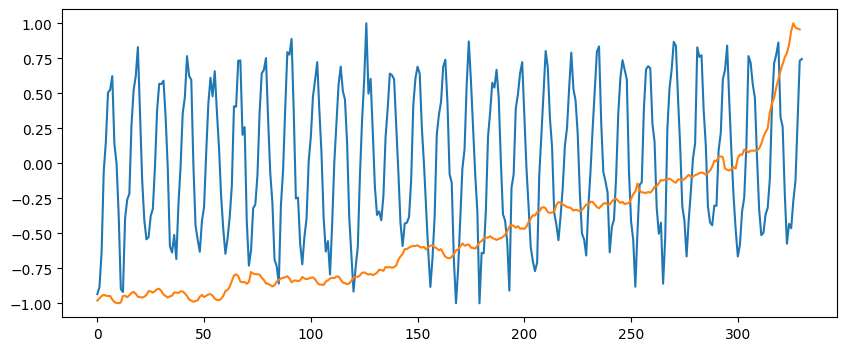

In [5]:
df_scaled['Air_Temperature'] = scaler.fit_transform(df['Air_Temperature'].values.reshape(-1,1)).flatten()

plt.figure(figsize=(10, 4))
plt.plot(df_scaled['Air_Temperature'])
plt.plot(df_scaled['Food_Price'])
df_scaled

In [6]:
#create sliding window
def lead_with_pct_change(df, column, windows):
    train_cols = []
    for window in reversed(windows):
        df['shift_pos_'+ str(window)] = df[column].shift(window).fillna(0)
        train_cols.append('shift_pos_' + str(window))
    return df[len(windows):], train_cols

In [7]:
df_windows, train_cols = lead_with_pct_change(df_scaled, "Food_Price", range(1,13))
df_windows['group'] = df.groupby(df.index//6, sort=False)["Food_Price"].agg(['ngroup'])
test_cols = ['Food_Price']
df_windows = df_windows.drop(columns = ["Air_Temperature"])
df_windows = df_windows.dropna()
df_windows

C:\Users\Nutzer\AppData\Local\Temp\ipykernel_20216\307390869.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_windows['group'] = df.groupby(df.index//6, sort=False)["Food_Price"].agg(['ngroup'])


,Unnamed: 0,Date,Food_Price,shift_pos_12,shift_pos_11,shift_pos_10,shift_pos_9,shift_pos_8,shift_pos_7,shift_pos_6,shift_pos_5,shift_pos_4,shift_pos_3,shift_pos_2,shift_pos_1,group
12,12,1997-01,-0.948229,-0.980926,-0.964578,-0.948229,-0.940054,-0.945504,-0.948229,-0.948229,-0.972752,-0.991826,-0.997275,-1.000000,-0.994550,2
13,13,1997-02,-0.945504,-0.964578,-0.948229,-0.940054,-0.945504,-0.948229,-0.948229,-0.972752,-0.991826,-0.997275,-1.000000,-0.994550,-0.948229,2
14,14,1997-03,-0.956403,-0.948229,-0.940054,-0.945504,-0.948229,-0.948229,-0.972752,-0.991826,-0.997275,-1.000000,-0.994550,-0.948229,-0.945504,2
15,15,1997-04,-0.942779,-0.940054,-0.945504,-0.948229,-0.948229,-0.972752,-0.991826,-0.997275,-1.000000,-0.994550,-0.948229,-0.945504,-0.956403,2
16,16,1997-05,-0.926431,-0.945504,-0.948229,-0.948229,-0.972752,-0.991826,-0.997275,-1.000000,-0.994550,-0.948229,-0.945504,-0.956403,-0.942779,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,325,2023-02,0.945504,0.223433,0.250681,0.362398,0.430518,0.465940,0.542234,0.599455,0.662125,0.708447,0.757493,0.787466,0.847411,54
326,326,2023-03,1.000000,0.250681,0.362398,0.430518,0.465940,0.542234,0.599455,0.662125,0.708447,0.757493,0.787466,0.847411,0.945504,54
327,327,2023-04,0.970027,0.362398,0.430518,0.465940,0.542234,0.599455,0.662125,0.708447,0.757493,0.787466,0.847411,0.945504,1.000000,54
328,328,2023-05,0.961853,0.430518,0.465940,0.542234,0.599455,0.662125,0.708447,0.757493,0.787466,0.847411,0.945504,1.000000,0.970027,54


In [8]:
train_df = df_windows.iloc[:-12, :]
test_df = df_windows.iloc[-12:, :]
train_df.shape, test_df.shape



((306, 16), (12, 16))

In [9]:
X_train = np.array(list(train_df.groupby('group').apply(lambda x: x[train_cols].values))).astype(np.float32)
y_train = np.array(list(train_df.groupby('group').apply(lambda x: x[test_cols].values))).astype(np.float32)
X_train.shape, y_train.shape

((51, 6, 12), (51, 6, 1))

In [11]:
from torch.utils.data import Dataset, DataLoader
class DS(Dataset):
    def __init__ (self,X_train,y_train):
        self.X_train = X_train
        self.y_train = y_train

    def __len__(self):
        return len(self.y_train)
    
    def __getitem__(self, idx):
        data = self.X_train[idx, :]
        labels = self.y_train[idx, :]
        return data, labels 
    


In [12]:
class Model(nn.Module):
    def __init__(self,input_size, hidden_size =100):
        super().__init__()
        input_size = input_size

        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers = 1, batch_first = True, bidirectional = False)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size*2, num_layers = 1, batch_first = True, bidirectional = False) 
        self.fc = nn.Linear(hidden_size*2, 1)

    def forward(self,x):
        #print (x.shape)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)

        #print x.shape

        x, _ = self.fc(x)

        #print x.shape

        return x

In [26]:
model = Model(input_size=len(train_cols))

In [30]:
db = DataBunch.create(DS(X_train,y_train), valid_ds=None, bs = 8)


In [31]:
learn = Learner(db, model, loss_func=nn.MSELoss())
learn.callbacks.append(ShowGraph(learn))
learn.callbacks.append(CSVLogger(learn))

In [36]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: DataLoader worker (pid(s) 20880, 9508, 19468, 1388, 9208, 3656, 5884, 13304, 6520, 20204, 8616, 21528, 21740, 21960, 22080, 22184) exited unexpectedly

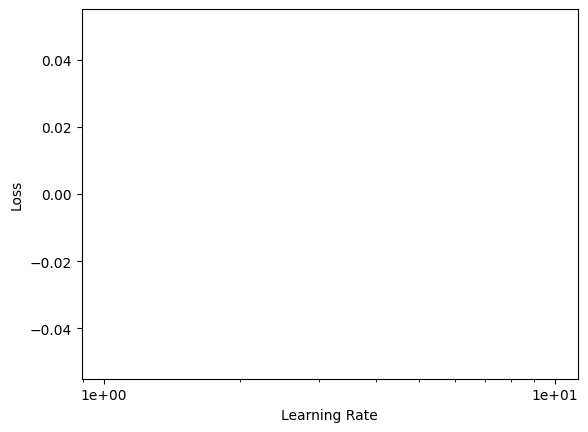

In [35]:
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(150, max_lr=1e-2)


epoch,train_loss,valid_loss,time


RuntimeError: DataLoader worker (pid(s) 1192, 1452, 18872, 19880, 16388, 19500, 5216, 20552, 1056, 12836, 12924, 12724, 3636, 20512, 19028, 20348) exited unexpectedly